In [1]:
# pytorch
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms

# fastmri
import fastmri
from fastmri.data import subsample
from fastmri.data import transforms, mri_data
from fastmri.evaluate import ssim, psnr, nmse
from fastmri.losses import SSIMLoss
from fastmri.models import Unet

# other
import random
import PIL.Image as Image
from glob import glob
from mymodels import VisionTransformer, ReconNet

# Device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = 'cuda'

In [ ]:
class ImagenetDataset(Dataset):
    def __init__(self, isval=False):

        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = [] 
            pattern   = "*.JPEG"        
            for dir, _, _ in os.walk('/media/hdd1/ImageNet/ILSVRC/Data/CLS-LOC/val/'):
                self.files.extend(glob(os.path.join(dir, pattern)))             
            # or uncomment following in case paths are already saved
#             self.files = torch.load('./imagenet_filepaths_val.pt') 
        else:
            ## combine paths of each imagenet training image into a single list       
            self.files = []  # get path of each imagenet images
            pattern   = "*.JPEG"        
            for dir, _, _ in os.walk('/media/hdd1/ImageNet/ILSVRC/Data/CLS-LOC/train/'):
                self.files.extend(glob(os.path.join(dir, pattern)))                 
            # or uncomment in case paths are already saved
#             self.files = torch.load('./imagenet_filepaths_train.pt')    

        self.transform = tvtransforms.Compose([      
            tvtransforms.Resize(320,),
            tvtransforms.RandomCrop(272),
            tvtransforms.Grayscale(1),
            tvtransforms.RandomVerticalFlip(p=0.5),
            tvtransforms.RandomHorizontalFlip(p=0.5),
            tvtransforms.ToTensor(),                  
            ])            
        
        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
        
    def get_mask_func(self, samp_style, factor, ):
        center_fractions = 0.08 * 4/factor
        if samp_style == 'random':
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor], 
                )
        elif samp_style == 'equidist':
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor], 
                )            
        return mask_func
        
    def add_gaussian_noise(self, x):
        noise = random.uniform(0.0, 0.0015)
        x = x + noise*x.norm()*1/2**0.5*torch.randn_like(x)

        return x

    def __len__(self, ):
        
        return len(self.files)
    
    def __getitem__(self, idx):
        image = Image.open(self.files[idx]).convert("RGB")
   
        y = self.transform(image)
        
        if random.uniform(0, 1) < 0.5:
            y = torch.rot90(y, 1, [-2,-1])
        
        if random.uniform(0, 1) < 0.5:
            samp_style = 'random'
        else:
            samp_style = 'equidist'
        factor = random.choice(self.factors)
        mask_func = self.get_mask_func(samp_style, factor)
        x = y.squeeze()
        x = torch.stack((x, torch.zeros_like(x)), -1)
        kspace = fastmri.fft2c(x)
#         kspace = self.add_gaussian_noise(kspace)
        masked_kspace, _ = transforms.apply_mask(kspace, mask_func) 
        zero_fill = fastmri.ifft2c(masked_kspace)
        x = fastmri.complex_abs(zero_fill)
        x = x.unsqueeze(0)
        x += 1e-6*torch.randn_like(x)  # For stability during training due to normalization step in network (i.e. when x is constant, network outputs inf)
        
        return (x, y)

In [ ]:
dataset = ImagenetDataset()
val_dataset = ImagenetDataset(isval=True)

In [ ]:
ntrain = len(dataset)
train_dataset, _ = torch.utils.data.random_split(dataset, [ntrain, len(dataset)-ntrain],generator=torch.Generator().manual_seed(42))

In [ ]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True,generator=torch.Generator().manual_seed(42))
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True,generator=torch.Generator().manual_seed(42))

In [ ]:
"""Init Model"""
# Vision Transformer
avrg_img_size = 340
patch_size = 10
depth = 10
num_heads = 16
embed_dim = 44

net = VisionTransformer(
    avrg_img_size=avrg_img_size, 
    patch_size=patch_size, 
    in_chans=1, embed_dim=embed_dim, 
    depth=depth, num_heads=num_heads,
    )


# Unet
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=64,
#     num_pool_layers=4,
#     )

model = ReconNet(net).to(device)

# Set biases to zero 
for name, param in model.named_parameters():
    if name.endswith('.bias'):
        nn.init.constant_(param, 0)
        param.requires_grad = False
            
print('#Params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

In [ ]:
# Save model
def save_model(path, model, train_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(), 
        }
    else:
        checkpoint = {
            'model' :  ReconNet(net),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        
    torch.save(train_hist, path + 'train_hist.pt')
    torch.save(checkpoint,  path + 'checkpoint.pth')

In [ ]:
"""Choose optimizer"""
criterion = SSIMLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
path = './' # Path for saving model checkpoint and loss history
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0004,
                                          total_steps=20, pct_start=0.1,
                                          anneal_strategy='linear',
                                          cycle_momentum=False,
                                          base_momentum=0., max_momentum=0., div_factor=0.1*20, final_div_factor=9)

In [ ]:
"""Train"""
for epoch in range(0, 20):  # loop over the dataset multiple times
    model.train()  
    train_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, targets = data
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device), torch.tensor([1.], device=device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True)
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()
    train_hist.append(train_loss/len(trainloader))
    save_model(path, model, train_hist, optimizer, scheduler=scheduler)
    print('Epoch {}, Train loss.: {:0.4e}'.format(epoch+1, train_hist[-1]))

1
 ssim: 0.9760232202464678
*ssim: 0.7634693069563969
 psnr: 35.874649604535364
*psnr: 27.278174837254653
 nmse: 0.0005257340660767761
*nmse: 0.003805517703624158


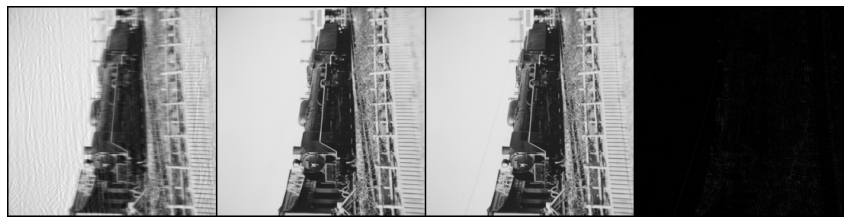

2
 ssim: 0.8866934203744815
*ssim: 0.645827568378927
 psnr: 30.705895938025478
*psnr: 22.08693575191407
 nmse: 0.0039028144835455835
*nmse: 0.028397116938847212


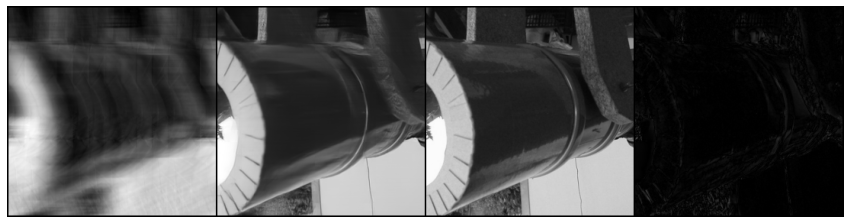

3
 ssim: 0.9132670499058656
*ssim: 0.7242188247921341
 psnr: 30.981800821020133
*psnr: 24.601139821612637
 nmse: 0.0023484211971743886
*nmse: 0.010205679156874098


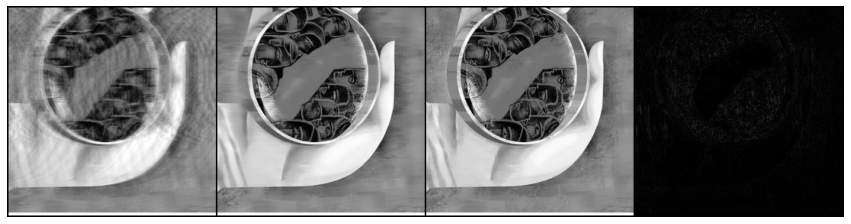

4
 ssim: 0.8989373787342694
*ssim: 0.718671714614333
 psnr: 31.55888881244109
*psnr: 25.52032178330437
 nmse: 0.0050749665987923865
*nmse: 0.020384019020236732


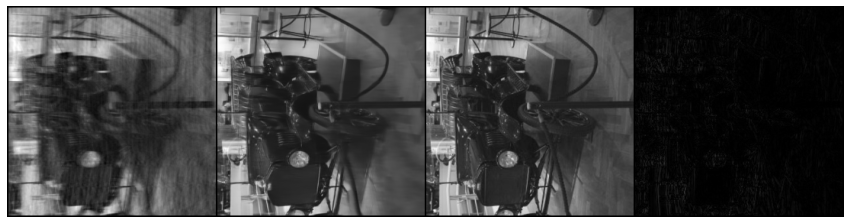

5
 ssim: 0.7924428936664227
*ssim: 0.7007391574288724
 psnr: 27.303166228942317
*psnr: 24.851517733702035
 nmse: 0.008731135216718063
*nmse: 0.01535449633945121


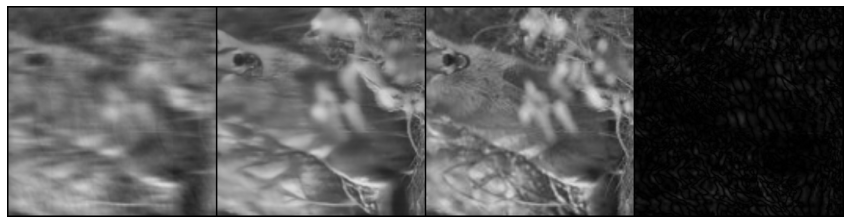

In [13]:
import matplotlib.pyplot as plt
from myutils import imshow

"""Example reconstructions"""
valloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0, generator=torch.Generator().manual_seed(1))
dataiter = iter(valloader)
model.eval()
maxval = torch.tensor([1.], device='cpu')
with torch.no_grad():
    for k in range(0,5):    
        inputs, targets = dataiter.next()
        outputs = model(inputs.to(device)).cpu()
        inputs_ = inputs
        plt.figure(figsize=(15,7))
        imshow(make_grid([inputs_[0], outputs[0], targets[0], (targets[0]-outputs[0]).abs()],normalize = True, value_range=(0,maxval[0])))    
        plt.axis('off')
        img_input = inputs_[0].numpy()
        img_noise = outputs[0].numpy()
        img = targets[0].numpy()
        print(k+1)
        print(' ssim:', ssim(img, img_noise, maxval[0].item()))
        print('*ssim:', ssim(img, img_input, maxval[0].item()))
        print(' psnr:', psnr(img, img_noise, maxval[0].item()))
        print('*psnr:', psnr(img, img_input, maxval[0].item()))
        print(' nmse:', nmse(img, img_noise, ))
        print('*nmse:', nmse(img, img_input))
        plt.show()